##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Embedding with MediaPipe Tasks

This notebook will show you how to use the MediaPipe Tasks Python API to compare two separate image files to determine how similar they are. These values will range from -1 to 1 with 1 being the same image This is done through a technique called cosine similarity.

## Preparation
You can start by installing the necessary dependencies for your project.


In [6]:
# !pip install -q mediapipe

The next step you will take is to download the off-the-shelf model that will be used for image embedding. In this case you will use mobilenet, but you may use any other appropriate model or a model that you have built for your own specific use-cases with MediaPipe Tasks.

In [7]:
# !wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

For the final preparation step, you will need to have two separate images that can be compared. You can download two provided images through the following code, or you can download your own from a different location.

In [8]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'burger_crop.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

# Performing Image Embedding
Now that you have retrieved the two images that will be compared, you can display them to confirm that they look correct. For this example you should see two separate, but similar, pictures of burgers.

burger.jpg


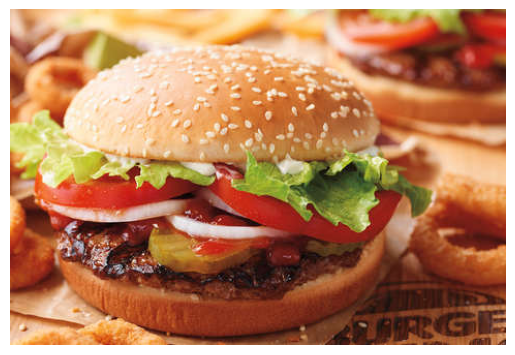

burger_crop.jpg


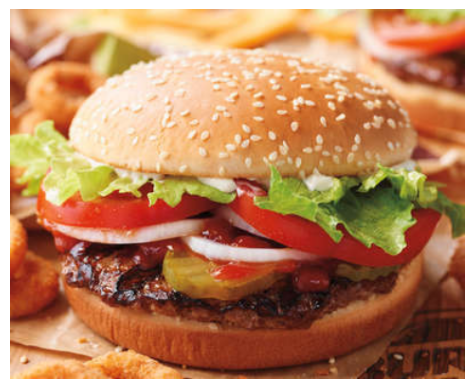

In [10]:
import cv2
import math
import matplotlib.pyplot as plt

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Assuming IMAGE_FILENAMES is already defined with image file names
IMAGE_FILENAMES = ['burger.jpg', 'burger_crop.jpg']

# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
    print(name)
    resize_and_show(image)


Once everything looks good, you can start performing inference. You will start by creating the options that are necessary for associating your model with the Image Embedder, as well as some customizations.

Next you will create the Image Embedder, then format your two images for MediaPipe so that you can use cosine similarity to compare them.

Finally, you will display the similarity value.

In [11]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create options for Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True #@param {type:"boolean"}
quantize = True #@param {type:"boolean"}
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)


# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:

  # Format images for MediaPipe
  first_image = mp.Image.create_from_file(IMAGE_FILENAMES[0])
  second_image = mp.Image.create_from_file(IMAGE_FILENAMES[1])
  first_embedding_result = embedder.embed(first_image)
  second_embedding_result = embedder.embed(second_image)

  # Calculate and print similarity
  similarity = vision.ImageEmbedder.cosine_similarity(
      first_embedding_result.embeddings[0],
      second_embedding_result.embeddings[0])
  print(similarity)

2024-09-15 13:55:42.563052: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 13:55:42.593460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 13:55:42.609210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 13:55:42.614124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 13:55:42.633360: I tensorflow/core/platform/cpu_feature_guar

0.9154104779706991


I0000 00:00:1726408545.262034    3618 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [14]:
import gradio as gr
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# Function to resize the image as needed
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_image(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, int(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (int(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return img

# Create options for the Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True
quantize = True
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

# Function to compute similarity
def compute_similarity(image1, image2):
    # Resize and format images
    img1 = cv2.cvtColor(np.array(image1), cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR)
    
    img1_resized = resize_image(img1)
    img2_resized = resize_image(img2)

    with vision.ImageEmbedder.create_from_options(options) as embedder:
        first_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img1_resized)
        second_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img2_resized)
        first_embedding_result = embedder.embed(first_image)
        second_embedding_result = embedder.embed(second_image)
        
        # Calculate similarity
        similarity = vision.ImageEmbedder.cosine_similarity(
            first_embedding_result.embeddings[0],
            second_embedding_result.embeddings[0]
        )
    return similarity

# Create Gradio interface
inputs = [
    gr.inputs.Image(type="pil", label="Upload First Image"),
    gr.inputs.Image(type="pil", label="Upload Second Image")
]

outputs = gr.outputs.Textbox(label="Cosine Similarity")

app = gr.Interface(fn=compute_similarity, inputs=inputs, outputs=outputs, title="Image Similarity Checker")

# App 실행
app.launch(inline=False, share=True)

/tmp/ipykernel_3618/2592182462.py:51: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Image(type="pil", label="Upload First Image"),
/tmp/ipykernel_3618/2592182462.py:51: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.inputs.Image(type="pil", label="Upload First Image"),
/tmp/ipykernel_3618/2592182462.py:52: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Image(type="pil", label="Upload Second Image")
/tmp/ipykernel_3618/2592182462.py:52: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.inputs.Image(type="pil", label="Upload Second Image")
/tmp/ipykernel_3618/2592182462.py:55: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in 

Running on local URL:  http://127.0.0.1:7867
IMPORTANT: You are using gradio version 3.40.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://14164a829220320da2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


I0000 00:00:1726408658.553549    3746 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1726408737.100065    3746 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.

In [15]:
app.close()

Closing server running on port: 7867
